In [112]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import networkx as nx
from functools import reduce
import pandas as pd
import shutil
import sys
import json
import os.path
from pyomo.environ import *
from pyomo.gdp import *
from pyomo.contrib.latex_printer import latex_printer
import script
# from IPython.display import display, Math, Latex

In [113]:
def WriteJson(dictionary: dict, name = "task.json"):
    with open(name, 'w') as f:
        json.dump(dictionary, f)
    
def ReadJson(name = "task.json") -> dict:
    with open(name, 'r') as f:
        m = json.loads(f.read())
        return m

In [114]:
def Gantt(JOBS, SCHEDULE={}, ax1=None, ax2=None):
    bw = 0.3
#     ax.figure(figsize=(12, 0.7*(len(JOBS.keys()))))
    idx = 0
    for j in sorted(JOBS.keys()):
        x = JOBS[j]['release']
        y = JOBS[j]['due']
        ax1.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='cyan', alpha=0.6)
        if j in SCHEDULE.keys():
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            ax1.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            ax1.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            ax1.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        idx += 1

    ax1.set_ylim(-0.5, idx-0.5)
    ax1.set_title('Job Schedule')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Jobs')
    ax1.set_yticks(range(len(JOBS)), JOBS.keys())
    ax1.grid()
    xlim = ax1.get_xlim()

    if SCHEDULE:
        for j in SCHEDULE.keys():
            if 'machine' not in SCHEDULE[j].keys():
                SCHEDULE[j]['machine'] = 1
        MACHINES = sorted(set([SCHEDULE[j]['machine'] for j in SCHEDULE.keys()]))

#         ax.figure(figsize=(12, 0.7*len(MACHINES)))
        for j in sorted(SCHEDULE.keys()):
            idx = MACHINES.index(SCHEDULE[j]['machine'])
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            ax2.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            ax2.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            ax2.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        ax2.set_xlim(xlim)
        ax2.set_ylim(-0.5, len(MACHINES)-0.5)
        ax2.set_title('Machine Schedule')
        ax2.set_yticks(range(len(MACHINES)), MACHINES)
        ax2.set_ylabel('Machines')
        ax2.grid()

def Kpi(JOBS, SCHEDULE):
    KPI = {}
    KPI['Makespan'] = max(SCHEDULE[job]['finish'] for job in SCHEDULE)
    KPI['Max Pastdue'] = max(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Sum of Pastdue'] = sum(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Number Pastdue'] = sum(SCHEDULE[job]['finish'] > JOBS[job]['due'] for job in SCHEDULE)
    KPI['Number on Time'] = sum(SCHEDULE[job]['finish'] <= JOBS[job]['due'] for job in SCHEDULE)
    KPI['Fraction on Time'] = KPI['Number on Time']/len(SCHEDULE)
    return KPI

In [115]:
#Создание метода решения
def ScheduleMachines(JOBS):

    # create model
    m = ConcreteModel()

    # index set to simplify notation
    m.J = Set(initialize=JOBS.keys())
    m.PAIRS = Set(initialize = m.J * m.J, dimen=2, filter=lambda m, j, k : j < k)

    #верхние границы того, сколько времени потребуется для обработки всех заданий
    #верхняя оценка, когда мы можем уложить все работы подряд
    tmax = max([JOBS[j]['release'] for j in m.J]) + sum([JOBS[j]['duration'] for j in m.J])

    # decision variables
    m.start      = Var(m.J, domain=NonNegativeReals, bounds=(0, tmax))
    m.pastdue    = Var(m.J, domain=NonNegativeReals, bounds=(0, tmax))
    m.early      = Var(m.J, domain=NonNegativeReals, bounds=(0, tmax))

    # additional decision variables for use in the objecive
    m.makespan   = Var(domain=NonNegativeReals, bounds=(0, tmax))
    m.maxpastdue = Var(domain=NonNegativeReals, bounds=(0, tmax))
    m.ispastdue  = Var(m.J, domain=Binary)

    # objective function
    #По сути из решения в Pyomo Cookbook необходимо лишь изменить целевую функцию.
    m.OBJ = Objective(expr = m.maxpastdue, sense = minimize)

    # constraints
    # работа начинается не раньше срока появления работы    
    m.c1 = Constraint(m.J, rule=lambda m, j: m.start[j] >= JOBS[j]['release'])
    # раньше или позже директивного срока мы заканчиваем работу    
    m.c2 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + JOBS[j]['duration'] + m.early[j] == JOBS[j]['due'] + m.pastdue[j])
    # Работы не пересекаются
    m.c3 = Disjunction(m.PAIRS, rule=lambda m, j, k:
        [m.start[j] + JOBS[j]['duration'] <= m.start[k],
         m.start[k] + JOBS[k]['duration'] <= m.start[j]])
    # выставляем максимальное запаздывание, которое будем минимизировать
    m.c4 = Constraint(m.J, rule=lambda m, j: m.pastdue[j] <= m.maxpastdue)
    # выставляем минимальное время окончания всех работ
    m.c5 = Constraint(m.J, rule=lambda m, j: m.start[j] + JOBS[j]['duration'] <= m.makespan)
    # Если есть запаздывание, то оно должно не превышать максимального значения
    m.c6 = Constraint(m.J, rule=lambda m, j: m.pastdue[j] <= tmax*m.ispastdue[j])

    TransformationFactory('gdp.hull').apply_to(m)
    result = SolverFactory('glpk', executable=r"C:\glpk\glpk-4.65\w32\glpsol.exe").solve(m)
    
    SCHEDULE = {}
    for j in m.J:
        start = m.start[j]() if m.start[j]() is not None else JOBS[j]["release"]
        try:
            SCHEDULE[j] = {'machine': "M1", 'start': start, 'finish': start + JOBS[j]['duration']}
        except:
            result.write()
    return SCHEDULE, m

## Алгоритм

In [116]:
def CalcMaxPastDue(jobs: dict, intervals: list):
    result = []
    
    for job in jobs:
        start_time = jobs[job]["release"]
        duration = jobs[job]["duration"]
        due = jobs[job]["due"]
        
        val = 0
        for interval in intervals:
            if duration <= interval[1] - max(interval[0], start_time):
                val = max(val, max(0, (max(interval[0], start_time) + duration) - due))
        
        result.append((job, val))
    
    return sorted(result, key=lambda x: -x[1])

def DoJob(job, jobs, intervals):
    new_intervals = []
    start_time = jobs[job]["release"]
    duration = jobs[job]["duration"]
    due = jobs[job]["due"]
    
    for i, interval in enumerate(intervals):
        if duration <= interval[1] - max(interval[0], start_time):
            interval1 = (interval[0], max(interval[0], start_time))
            interval2 = (max(interval[0], start_time) + duration, interval[1])
            info = {
                'start': max(interval[0], start_time),
                'finish': max(interval[0], start_time) + duration,
                'machine': 'M1'
            }
            jobs.pop(job)
            if abs(interval1[0] - interval1[1]) > 0:
                new_intervals.append(interval1)
            if abs(interval2[0] - interval2[1]) > 0:
                new_intervals.append(interval2)
            
            for j in range(i + 1, len(intervals)):
                new_intervals.append(intervals[j])
            
            break
        new_intervals.append(interval)
        
    return info, new_intervals

def Solve(jobs: dict):
    releases = list(map(lambda x: float(jobs[x]["release"]), jobs))
    durations = list(map(lambda x: float(jobs[x]["duration"]), jobs))
    intervals = [(min(releases), max(releases) + sum(durations))]
    
    result = {}
    while jobs:
        job = CalcMaxPastDue(jobs, intervals)[0]
        info, intervals = DoJob(job[0], jobs, intervals)
        result[job[0]] = info
    
    return result

---

In [117]:
def Test(name, verbose = False):
    DATA = ReadJson(name=name)

    #Задание словаря работ
    JOBS = DATA["JOBS"]

    SCHEDULE1, MODEL = ScheduleMachines(JOBS)
    SCHEDULE2 = Solve(JOBS.copy())

    if not verbose:
        fig, ax = plt.subplots(3, 2, figsize=(15,14))
        fig.suptitle(f"{name}")
        ax[0][0].get_xaxis().set_visible(False)
        ax[0][0].get_yaxis().set_visible(False)
        ax[0][0].set_axis_off()
        ax[0][0].text(0.5, 0.5, f"Best: {Kpi(JOBS, SCHEDULE1)['Max Pastdue']}\n"
                     f"Greedy: {Kpi(JOBS, SCHEDULE2)['Max Pastdue']}")
    
        Gantt(JOBS, SCHEDULE1, ax[1][0], ax[2][0]) 
        Gantt(JOBS, SCHEDULE2, ax[1][1], ax[2][1])

    return len(JOBS), Kpi(JOBS, SCHEDULE1)['Max Pastdue'], Kpi(JOBS, SCHEDULE2)['Max Pastdue']
    

In [118]:
df = pd.DataFrame(columns=["Jobs count", "Max release", "Max duration", "Max due", "Score", "my Score", "Delta"])
idx = 0
for m in range(4):
    for max_release in [5, 10, 15, 20, 25]:
        for max_duration in [2, 4, 8, 16]:
            for max_due in [5, 10, 15, 20, 25, 30]:
                print(m, max_release, max_duration, max_due)
                idx += 1

                WriteJson(script.create_task(m+4, max_duration, max_release, max_due))
                DATA = ReadJson(name="task.json")
                JOBS = DATA["JOBS"]
                
                jobs_count, s1, s2 = Test("task.json", verbose = True)
                
                df.loc[idx] = [jobs_count, max_release, max_duration, max_due, s1, s2, abs(s2-s1) if s1 is not None else None]

0 5 2 5
0 5 2 10
0 5 2 15
0 5 2 20
0 5 2 25
0 5 2 30
0 5 4 5
0 5 4 10
0 5 4 15
0 5 4 20
0 5 4 25
0 5 4 30
0 5 8 5
0 5 8 10
0 5 8 15
0 5 8 20
0 5 8 25
0 5 8 30
0 5 16 5
0 5 16 10
0 5 16 15
0 5 16 20
0 5 16 25
0 5 16 30
0 10 2 5
0 10 2 10
0 10 2 15
0 10 2 20
0 10 2 25
0 10 2 30
0 10 4 5
0 10 4 10
0 10 4 15
0 10 4 20
0 10 4 25
0 10 4 30
0 10 8 5
0 10 8 10
0 10 8 15
0 10 8 20
0 10 8 25
0 10 8 30
0 10 16 5
0 10 16 10
0 10 16 15
0 10 16 20
0 10 16 25
0 10 16 30
0 15 2 5
0 15 2 10
0 15 2 15
0 15 2 20
0 15 2 25
0 15 2 30
0 15 4 5
0 15 4 10
0 15 4 15
0 15 4 20
0 15 4 25
0 15 4 30
0 15 8 5
0 15 8 10
0 15 8 15
0 15 8 20
0 15 8 25
0 15 8 30
0 15 16 5
0 15 16 10
0 15 16 15
0 15 16 20
0 15 16 25
0 15 16 30
0 20 2 5
0 20 2 10
0 20 2 15
0 20 2 20
0 20 2 25
0 20 2 30
0 20 4 5
0 20 4 10
0 20 4 15
0 20 4 20
0 20 4 25
0 20 4 30
0 20 8 5
0 20 8 10
0 20 8 15
0 20 8 20
0 20 8 25
0 20 8 30
0 20 16 5
0 20 16 10
0 20 16 15
0 20 16 20
0 20 16 25
0 20 16 30
0 25 2 5
0 25 2 10
0 25 2 15
0 25 2 20
0 25 2 25
0 25 2 

In [119]:
df

,Jobs count,Max release,Max duration,Max due,Score,my Score,Delta
1,4.0,5.0,2.0,5.0,7.0,9.0,2.0
2,4.0,5.0,2.0,10.0,7.0,9.0,2.0
3,4.0,5.0,2.0,15.0,5.0,5.0,0.0
4,4.0,5.0,2.0,20.0,3.0,3.0,0.0
5,4.0,5.0,2.0,25.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
476,7.0,25.0,16.0,10.0,62.0,63.0,1.0
477,7.0,25.0,16.0,15.0,81.0,90.0,9.0
478,7.0,25.0,16.0,20.0,44.0,54.0,10.0
479,7.0,25.0,16.0,25.0,53.0,55.0,2.0


In [120]:
df.to_excel('out.xlsx', engine='xlsxwriter')

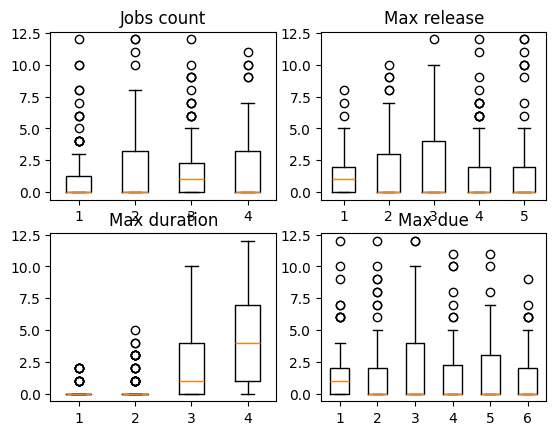

In [152]:
for idx, param in enumerate(['Jobs count', 'Max release', 'Max duration', 'Max due']):
    df1 = df.groupby([param]).mean()
    plt.subplot(221 + idx, title=param)
    plt.boxplot([df[df[param] == i]["Delta"].values for i in df1.index.values])

plt.show()

(7, 45.0, 52)

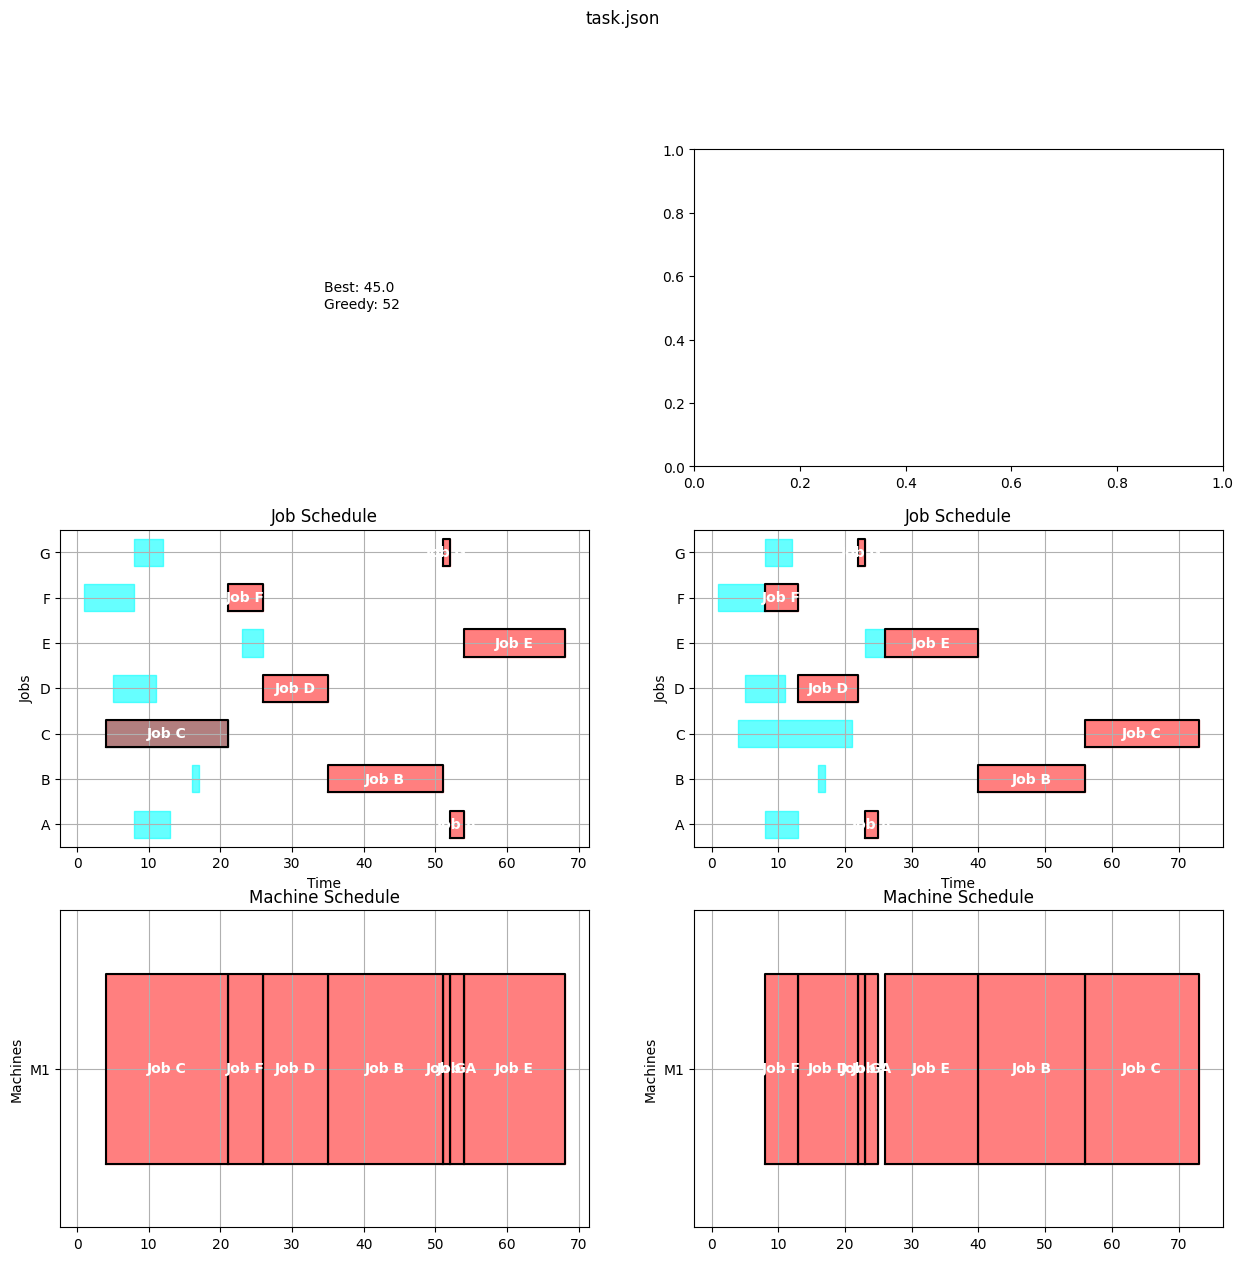

In [121]:
Test("task.json")